
# Plot classification boundaries with different SVM Kernels
This example shows how different kernels in a :class:`~sklearn.svm.SVC` (Support Vector
Classifier) influence the classification boundaries in a binary, two-dimensional
classification problem.

SVCs aim to find a hyperplane that effectively separates the classes in their training
data by maximizing the margin between the outermost data points of each class. This is
achieved by finding the best weight vector $w$ that defines the decision boundary
hyperplane and minimizes the sum of hinge losses for misclassified samples, as measured
by the :func:`~sklearn.metrics.hinge_loss` function. By default, regularization is
applied with the parameter `C=1`, which allows for a certain degree of misclassification
tolerance.

If the data is not linearly separable in the original feature space, a non-linear kernel
parameter can be set. Depending on the kernel, the process involves adding new features
or transforming existing features to enrich and potentially add meaning to the data.
When a kernel other than `"linear"` is set, the SVC applies the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick)_, which
computes the similarity between pairs of data points using the kernel function without
explicitly transforming the entire dataset. The kernel trick surpasses the otherwise
necessary matrix transformation of the whole dataset by only considering the relations
between all pairs of data points. The kernel function maps two vectors (each pair of
observations) to their similarity using their dot product.

The hyperplane can then be calculated using the kernel function as if the dataset were
represented in a higher-dimensional space. Using a kernel function instead of an
explicit matrix transformation improves performance, as the kernel function has a time
complexity of $O({n}^2)$, whereas matrix transformation scales according to the
specific transformation being applied.

In this example, we compare the most common kernel types of Support Vector Machines: the
linear kernel (`"linear"`), the polynomial kernel (`"poly"`), the radial basis function
kernel (`"rbf"`) and the sigmoid kernel (`"sigmoid"`).


In [ ]:
# Code source: Gaël Varoquaux
# License: BSD 3 clause

## Creating a dataset
We create a two-dimensional classification dataset with 16 samples and two classes. We
plot the samples with the colors matching their respective targets.



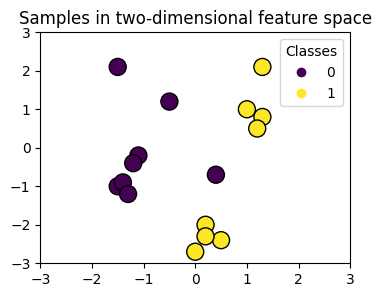

In [1]:
import matplotlib.pyplot as plt
import numpy as np

X = np.array(
    [
        [0.4, -0.7],
        [-1.5, -1.0],
        [-1.4, -0.9],
        [-1.3, -1.2],
        [-1.1, -0.2],
        [-1.2, -0.4],
        [-0.5, 1.2],
        [-1.5, 2.1],
        [1.0, 1.0],
        [1.3, 0.8],
        [1.2, 0.5],
        [0.2, -2.0],
        [0.5, -2.4],
        [0.2, -2.3],
        [0.0, -2.7],
        [1.3, 2.1],
    ]
)

y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

# Plotting settings
fig, ax = plt.subplots(figsize=(4, 3))
x_min, x_max, y_min, y_max = -3, 3, -3, 3
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Plot samples by color and add legend
scatter = ax.scatter(X[:, 0], X[:, 1], s=150, c=y, label=y, edgecolors="k")
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.set_title("Samples in two-dimensional feature space")
_ = plt.show()

We can see that the samples are not clearly separable by a straight line.

## Training SVC model and plotting decision boundaries
We define a function that fits a :class:`~sklearn.svm.SVC` classifier,
allowing the `kernel` parameter as an input, and then plots the decision
boundaries learned by the model using
:class:`~sklearn.inspection.DecisionBoundaryDisplay`.

Notice that for the sake of simplicity, the `C` parameter is set to its
default value (`C=1`) in this example and the `gamma` parameter is set to
`gamma=2` across all kernels, although it is automatically ignored for the
linear kernel. In a real classification task, where performance matters,
parameter tuning (by using :class:`~sklearn.model_selection.GridSearchCV` for
instance) is highly recommended to capture different structures within the
data.

Setting `response_method="predict"` in
:class:`~sklearn.inspection.DecisionBoundaryDisplay` colors the areas based
on their predicted class. Using `response_method="decision_function"` allows
us to also plot the decision boundary and the margins to both sides of it.
Finally the support vectors used during training (which always lay on the
margins) are identified by means of the `support_vectors_` attribute of
the trained SVCs, and plotted as well.



In [2]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay


def plot_training_data_with_decision_boundary(kernel):
    # Train the SVC
    clf = svm.SVC(kernel=kernel, gamma=2).fit(X, y)

    # Settings for plotting
    _, ax = plt.subplots(figsize=(4, 3))
    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    # Plot bigger circles around samples that serve as support vectors
    ax.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=250,
        facecolors="none",
        edgecolors="k",
    )
    # Plot samples by color and add legend
    ax.scatter(X[:, 0], X[:, 1], c=y, s=150, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.set_title(f" Decision boundaries of {kernel} kernel in SVC")

    _ = plt.show()

### Linear kernel
Linear kernel is the dot product of the input samples:

\begin{align}K(\mathbf{x}_1, \mathbf{x}_2) = \mathbf{x}_1^\top \mathbf{x}_2\end{align}

It is then applied to any combination of two data points (samples) in the
dataset. The dot product of the two points determines the
:func:`~sklearn.metrics.pairwise.cosine_similarity` between both points. The
higher the value, the more similar the points are.



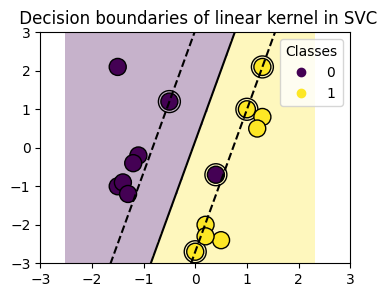

In [3]:
plot_training_data_with_decision_boundary("linear")

Training a :class:`~sklearn.svm.SVC` on a linear kernel results in an
untransformed feature space, where the hyperplane and the margins are
straight lines. Due to the lack of expressivity of the linear kernel, the
trained classes do not perfectly capture the training data.

### Polynomial kernel
The polynomial kernel changes the notion of similarity. The kernel function
is defined as:

\begin{align}K(\mathbf{x}_1, \mathbf{x}_2) = (\gamma \cdot \
      \mathbf{x}_1^\top\mathbf{x}_2 + r)^d\end{align}

where ${d}$ is the degree (`degree`) of the polynomial, ${\gamma}$
(`gamma`) controls the influence of each individual training sample on the
decision boundary and ${r}$ is the bias term (`coef0`) that shifts the
data up or down. Here, we use the default value for the degree of the
polynomial in the kernel function (`degree=3`). When `coef0=0` (the default),
the data is only transformed, but no additional dimension is added. Using a
polynomial kernel is equivalent to creating
:class:`~sklearn.preprocessing.PolynomialFeatures` and then fitting a
:class:`~sklearn.svm.SVC` with a linear kernel on the transformed data,
although this alternative approach would be computationally expensive for most
datasets.



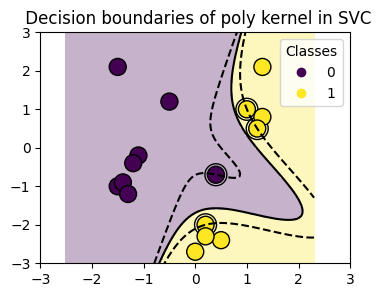

In [4]:
plot_training_data_with_decision_boundary("poly")

The polynomial kernel with `gamma=2`` adapts well to the training data,
causing the margins on both sides of the hyperplane to bend accordingly.

### RBF kernel
The radial basis function (RBF) kernel, also known as the Gaussian kernel, is
the default kernel for Support Vector Machines in scikit-learn. It measures
similarity between two data points in infinite dimensions and then approaches
classification by majority vote. The kernel function is defined as:

\begin{align}K(\mathbf{x}_1, \mathbf{x}_2) = \exp\left(-\gamma \cdot
      {\|\mathbf{x}_1 - \mathbf{x}_2\|^2}\right)\end{align}

where ${\gamma}$ (`gamma`) controls the influence of each individual
training sample on the decision boundary.

The larger the euclidean distance between two points
$\|\mathbf{x}_1 - \mathbf{x}_2\|^2$
the closer the kernel function is to zero. This means that two points far away
are more likely to be dissimilar.



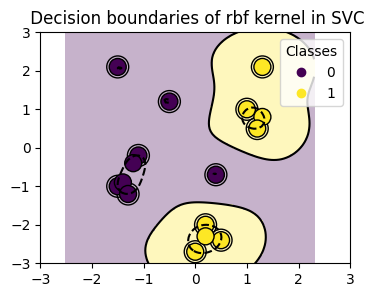

In [5]:
plot_training_data_with_decision_boundary("rbf")

In the plot we can see how the decision boundaries tend to contract around
data points that are close to each other.

### Sigmoid kernel
The sigmoid kernel function is defined as:

\begin{align}K(\mathbf{x}_1, \mathbf{x}_2) = \tanh(\gamma \cdot
      \mathbf{x}_1^\top\mathbf{x}_2 + r)\end{align}

where the kernel coefficient ${\gamma}$ (`gamma`) controls the influence
of each individual training sample on the decision boundary and ${r}$ is
the bias term (`coef0`) that shifts the data up or down.

In the sigmoid kernel, the similarity between two data points is computed
using the hyperbolic tangent function ($\tanh$). The kernel function
scales and possibly shifts the dot product of the two points
($\mathbf{x}_1$ and $\mathbf{x}_2$).



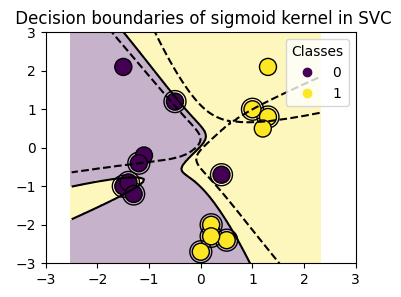

In [6]:
plot_training_data_with_decision_boundary("sigmoid")

We can see that the decision boundaries obtained with the sigmoid kernel
appear curved and irregular. The decision boundary tries to separate the
classes by fitting a sigmoid-shaped curve, resulting in a complex boundary
that may not generalize well to unseen data. From this example it becomes
obvious, that the sigmoid kernel has very specific use cases, when dealing
with data that exhibits a sigmoidal shape. In this example, careful fine
tuning might find more generalizable decision boundaries. Because of it's
specificity, the sigmoid kernel is less commonly used in practice compared to
other kernels.

## Conclusion
In this example, we have visualized the decision boundaries trained with the
provided dataset. The plots serve as an intuitive demonstration of how
different kernels utilize the training data to determine the classification
boundaries.

The hyperplanes and margins, although computed indirectly, can be imagined as
planes in the transformed feature space. However, in the plots, they are
represented relative to the original feature space, resulting in curved
decision boundaries for the polynomial, RBF, and sigmoid kernels.

Please note that the plots do not evaluate the individual kernel's accuracy or
quality. They are intended to provide a visual understanding of how the
different kernels use the training data.

For a comprehensive evaluation, fine-tuning of :class:`~sklearn.svm.SVC`
parameters using techniques such as
:class:`~sklearn.model_selection.GridSearchCV` is recommended to capture the
underlying structures within the data.

